In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import CQNet

In [2]:
nums_photo = 5

In [3]:
# 深度卷积神经网络模型
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )

        # 新增一个更深的编码器分支
        self.encoder3 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )
                # 新增一个更深的编码器分支
        self.encoder4 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=25, stride=1, padding=12),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
        )

        # 解码器部分
        # 解码器部分，调整卷积转置层的参数来减少输出尺寸
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(384, 128, kernel_size=2, stride=2),  # 将通道从 384 减少到 128
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 1, kernel_size=2, stride=2),  # 减少通道数，增加空间分辨率
            # nn.ReLU(),
            # nn.BatchNorm2d(64),
            # nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # 减少输出到目标大小
            nn.Sigmoid(),
        )


    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)
        encoded3 = self.encoder3(x)
        encoded4 = self.encoder4(x)

        # 将三个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2, encoded3, encoded4), dim=1)  # 在通道维度拼接

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded

# 2. 加载训练好的模型
def load_trained_model(model_path):
    # 定义模型架构
    model = DeepConvNet()

    # 加载训练好的权重
    model.load_state_dict(torch.load(model_path))

    # 切换到评估模式
    model.eval()

    return model


# 3. 预处理新数据
def preprocess_new_data(new_sonar_data):
    # 对新数据进行预处理，确保形状和输入的训练数据一致
    new_data = np.moveaxis(new_sonar_data, -1, 0)  # 调整轴顺序
    new_data = np.expand_dims(new_data, axis=1)  # 扩展通道维度
    new_data = (new_data - np.min(new_data)) / (np.max(new_data) - np.min(new_data))  # 归一化
    new_data_tensor = torch.tensor(new_data, dtype=torch.float32)
    return new_data_tensor


# 4. 使用模型进行推断
def detect_anomalies(model, data_tensor):
    with torch.no_grad():  # 禁用梯度计算以加快推断速度
        predictions = model(data_tensor)
    return predictions


# 5. 可视化原始数据与异常点
def plot_anomalies(original_data, predictions, slice_idx):
    original_img = original_data[slice_idx, 0, :, :].cpu().numpy()  # 获取原始数据
    prediction_mask = predictions[slice_idx, 0, :, :].cpu().numpy()  # 获取模型预测的异常点

    plt.figure(figsize=(10, 5))

    # 显示原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f"Original Image (Slice {slice_idx})")
    plt.colorbar()

    # 显示预测的异常点
    plt.subplot(1, 2, 2)
    plt.imshow(original_img, cmap='gray')  # 灰度图作为背景
    plt.imshow(prediction_mask, cmap='Reds', alpha=0.5)  # 红色的异常点叠加显示
    plt.title(f"Predicted Anomalies (Slice {slice_idx})")
    plt.colorbar()

    plt.show()


# 6. 综合步骤：加载模型、处理新数据、进行预测并可视化
def run_anomaly_detection(model_path, new_sonar_data):
    # 加载训练好的模型
    model = load_trained_model(model_path)

    # 预处理新数据
    data_tensor = preprocess_new_data(new_sonar_data)

    # 使用模型进行推断，检测异常点
    predictions = detect_anomalies(model, data_tensor)

    # 可视化异常点
    for slice_idx in range(data_tensor.shape[0]):
        plot_anomalies(data_tensor, predictions, slice_idx)

In [8]:
# 假设有新的声呐数据（替换为实际的数据文件路径）
file_path = "./data/go15-22m.dat"

# 假设有新的声呐数据（替换为实际的数据文件路径）
file_path1 = "./data/go22-26m.dat"

# 读取并处理声呐数据

img_8bit_matrix = CQNet.read_sonar_data(file_path1, nums_photo)
new_sonar_data = CQNet.reshape_img_matrix(img_8bit_matrix, nums_photo)  # 重新调整数据形状

# 模型文件路径
trained_model_path = './model/SuperDeep.pth'

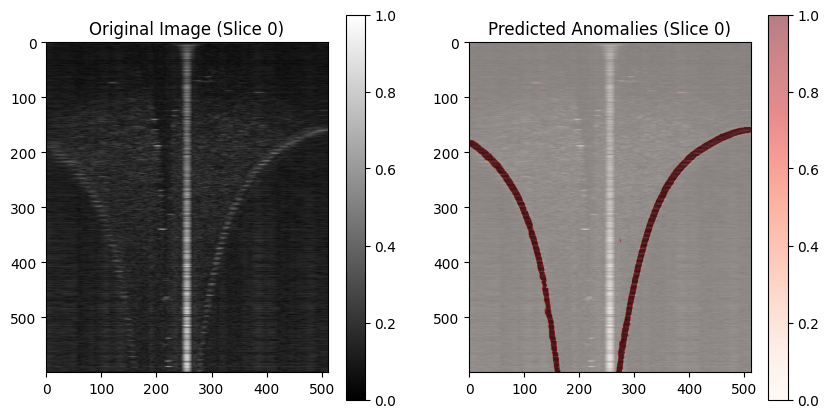

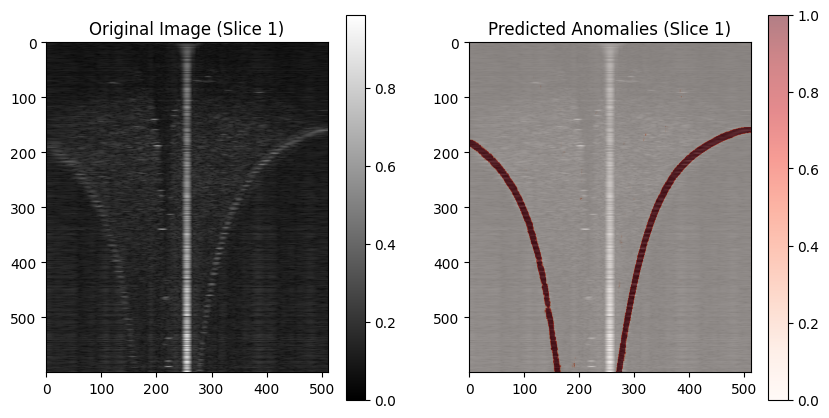

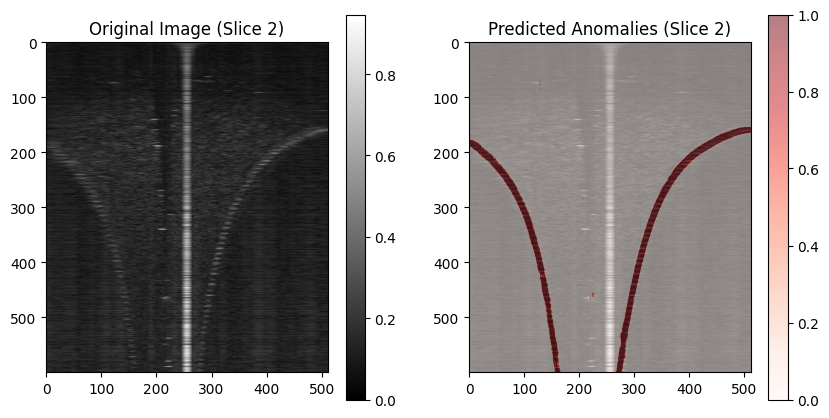

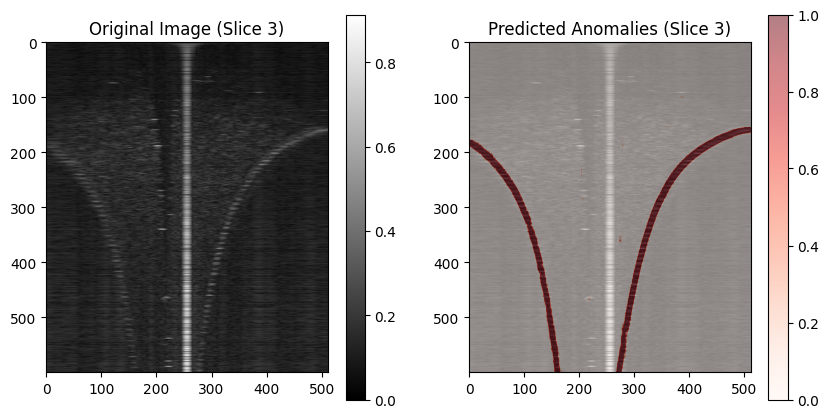

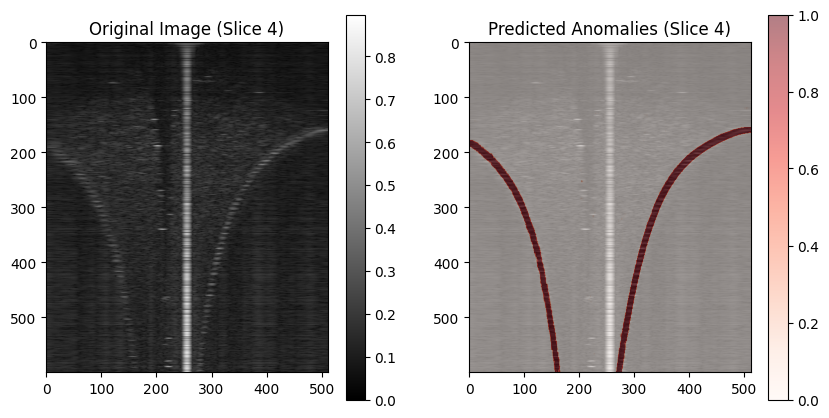

In [9]:
# 运行异常点检测
run_anomaly_detection(trained_model_path, new_sonar_data)